In [ ]:
#import required libraries

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import classification_report, confusion_matrix

SEED = 42
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  


DATA_DIR = r"/kaggle/input/ricediseaseclassification/rice leaf diseases dataset"

assert os.path.isdir(DATA_DIR), f"DATA_DIR not found: {DATA_DIR}"

# 1) Load train and validation 
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# 2) Performance optimizations
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# 3) Data augmentation & normalization layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ],
    name="data_augmentation"
)

preprocess_input = layers.Rescaling(1./255)  # simple rescale to [0,1]

def plot_history(history, model_name="Model"):
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Train Acc")
    plt.plot(epochs_range, val_acc, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_and_report(model, model_name="Model", dataset=val_ds):
    y_true = []
    y_pred = []

    for batch_images, batch_labels in dataset:
        preds = model.predict(batch_images, verbose=0)
        y_true.extend(batch_labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print(f"=== Classification Report: {model_name} ===")
    print(classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=4
    ))

model_accuracies = {}


Model: "custom_vgg_like"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,978,147 (99.10 MB)

 Trainable params: 25,978,147 (99.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1765307118.496537     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 147ms/step - accuracy: 0.5600 - loss: 0.9150 - val_accuracy: 0.8056 - val_loss: 0.5465
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.8014 - loss: 0.5554 - val_accuracy: 0.7821 - val_loss: 0.5696
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.8121 - loss: 0.5103 - val_accuracy: 0.8707 - val_loss: 0.3491
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.8674 - loss: 0.3876 - val_accuracy: 0.8600 - val_loss: 0.3538
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.8545 - loss: 0.3652 - val_accuracy: 0.8964 - val_loss: 0.2561
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.8893 - loss: 0.2916 - val_accuracy: 0.9327 - val_loss: 0.1882
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.8876 - loss: 0.2732 - val_accuracy: 0.9038 - val_loss: 0.2366
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 0.9094 - loss: 0.2321 - val

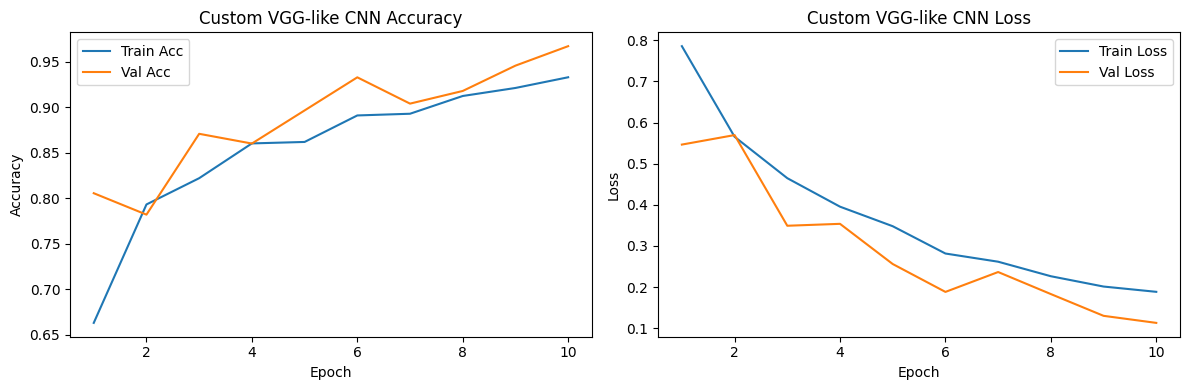

=== Classification Report: Custom VGG-like CNN ===
                 precision    recall  f1-score   support

Bacterialblight     0.9778    0.9968    0.9872       309
      Brownspot     0.9525    0.9799    0.9660       348
       Leafsmut     0.9734    0.9176    0.9446       279

       accuracy                         0.9669       936
      macro avg     0.9679    0.9647    0.9659       936
   weighted avg     0.9671    0.9669    0.9666       936

Custom CNN Val Accuracy: 0.9668803215026855


In [ ]:
#custom CNN

def build_custom_vgg_like(input_shape=IMG_SIZE + (3,), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = preprocess_input(x)

    # Block 1
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3 (like VGG but fewer filters/blocks)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="custom_vgg_like")
    return model

custom_cnn = build_custom_vgg_like(num_classes=num_classes)

custom_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

custom_cnn.summary()

EPOCHS = 10  

history_custom = custom_cnn.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

plot_history(history_custom, model_name="Custom VGG-like CNN")
evaluate_and_report(custom_cnn, model_name="Custom VGG-like CNN")

# validation accuracy
val_acc_custom = history_custom.history["val_accuracy"][-1]
model_accuracies["Custom_CNN"] = val_acc_custom
print("Custom CNN Val Accuracy:", val_acc_custom)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg19_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,156,483 (76.89 MB)

 Trainable params: 132,099 (516.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.3872 - loss: 1.1646 - val_accuracy: 0.7051 - val_loss: 0.8721
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 257ms/step - accuracy: 0.5826 - loss: 0.9158 - val_accuracy: 0.7147 - val_loss: 0.7929
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 268ms/step - accuracy: 0.6498 - loss: 0.8293 - val_accuracy: 0.6987 - val_loss: 0.7485
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 266ms/step - accuracy: 0.6923 - loss: 0.7778 - val_accuracy: 0.7276 - val_loss: 0.7193
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 265ms/step - accuracy: 0.6916 - loss: 0.7676 - val_accuracy: 0.7179 - val_loss: 0.6954
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 264ms/step - accuracy: 0.7113 - loss: 0.7307 - val_accuracy: 0.7115 - val_loss: 0.6846
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 266ms/step - accuracy: 0.7255 - loss: 0.7036 - val_accuracy: 0.7126 - val_loss: 0.6660
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 263ms/step - accuracy: 0.7250 - loss: 0

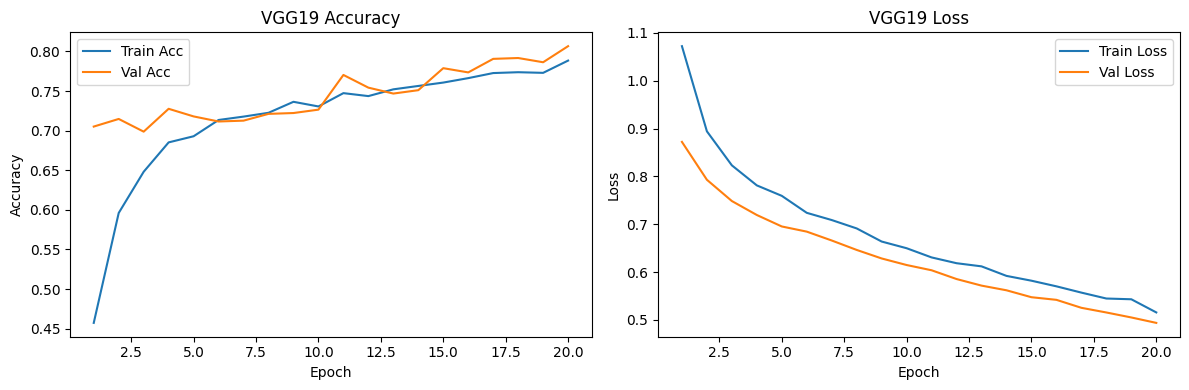

=== Classification Report: VGG19 ===
                 precision    recall  f1-score   support

Bacterialblight     0.8532    0.8091    0.8306       309
      Brownspot     0.7832    0.8822    0.8297       348
       Leafsmut     0.7888    0.7097    0.7472       279

       accuracy                         0.8066       936
      macro avg     0.8084    0.8003    0.8025       936
   weighted avg     0.8080    0.8066    0.8054       936

VGG19 Val Accuracy: 0.8066239356994629


In [ ]:
#VGG19
from tensorflow.keras.applications import VGG19

def build_vgg19_model(input_shape=IMG_SIZE + (3,), num_classes=3):
    base_model = VGG19(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # start with frozen base

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="vgg19_transfer")
    return model

vgg19_model = build_vgg19_model(num_classes=num_classes)
vgg19_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

vgg19_model.summary()

EPOCHS_VGG = 20  # adjust

history_vgg19 = vgg19_model.fit(
    train_ds,
    epochs=EPOCHS_VGG,
    validation_data=val_ds
)

plot_history(history_vgg19, model_name="VGG19")
evaluate_and_report(vgg19_model, model_name="VGG19")

val_acc_vgg = history_vgg19.history["val_accuracy"][-1]
model_accuracies["VGG19"] = val_acc_vgg
print("VGG19 Val Accuracy:", val_acc_vgg)


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv3_small_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,087,603 (4.15 MB)

 Trainable params: 148,483 (580.01 KB)

 Non-trainable params: 939,120 (3.58 MB)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.5515 - loss: 0.9209 - val_accuracy: 0.8066 - val_loss: 0.4795
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7965 - loss: 0.5122 - val_accuracy: 0.8654 - val_loss: 0.3512
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8532 - loss: 0.3859 - val_accuracy: 0.9113 - val_loss: 0.2777
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8954 - loss: 0.3157 - val_accuracy: 0.9348 - val_loss: 0.2275
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9127 - loss: 0.2605 - val_accuracy: 0.9530 - val_loss: 0.1913
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9255 - loss: 0.2274 - val_accuracy: 0.9605 - val_loss: 0.1631
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9369 - loss: 0.1962 - val_accuracy: 0.9637 - val_loss: 0.1439
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9451 - loss: 0.1790 - val_acc

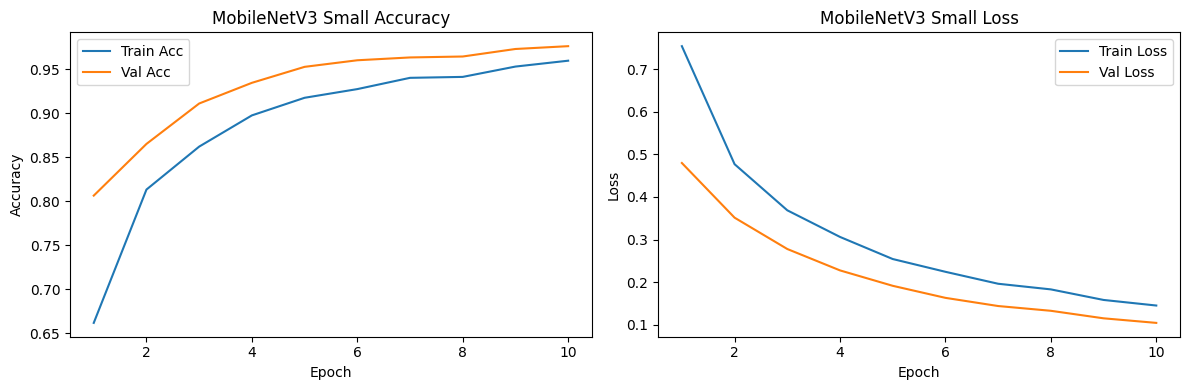

=== Classification Report: MobileNetV3 Small ===
                 precision    recall  f1-score   support

Bacterialblight     0.9624    0.9935    0.9777       309
      Brownspot     0.9746    0.9943    0.9844       348
       Leafsmut     0.9962    0.9355    0.9649       279

       accuracy                         0.9765       936
      macro avg     0.9777    0.9744    0.9756       936
   weighted avg     0.9770    0.9765    0.9764       936

MobileNetV3 Small Val Accuracy: 0.9764957427978516


In [ ]:
#MobilenetV3
from tensorflow.keras.applications import MobileNetV3Small

def build_mobilenetv3_model(input_shape=IMG_SIZE + (3,), num_classes=3):
    base_model = MobileNetV3Small(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
        include_preprocessing=False  # we already rescale
    )
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="mobilenetv3_small_transfer")
    return model

mobilenet_model = build_mobilenetv3_model(num_classes=num_classes)
mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

mobilenet_model.summary()

EPOCHS_MOB = 10  # adjust

history_mob = mobilenet_model.fit(
    train_ds,
    epochs=EPOCHS_MOB,
    validation_data=val_ds
)

plot_history(history_mob, model_name="MobileNetV3 Small")
evaluate_and_report(mobilenet_model, model_name="MobileNetV3 Small")

val_acc_mob = history_mob.history["val_accuracy"][-1]
model_accuracies["MobileNetV3_Small"] = val_acc_mob
print("MobileNetV3 Small Val Accuracy:", val_acc_mob)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 189ms/step - accuracy: 0.3529 - loss: 1.2540 - val_accuracy: 0.6036 - val_loss: 0.9693
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - accuracy: 0.4934 - loss: 1.0160 - val_accuracy: 0.6464 - val_loss: 0.9179
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - accuracy: 0.5480 - loss: 0.9442 - val_accuracy: 0.6090 - val_loss: 0.8784
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.5629 - loss: 0.9273 - val_accuracy: 0.6154 - val_loss: 0.8607
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - accuracy: 0.5746 - loss: 0.8978 - val_accuracy: 0.6784 - val_loss: 0.8700
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - accuracy: 0.5941 - loss: 0.8871 - val_accuracy: 0.6271 - val_loss: 0.8422
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - accuracy: 0.6019 - loss: 0.8790 - val_accuracy: 0.6752 - val_loss: 0.8444
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - accuracy: 0.6198 - loss: 0

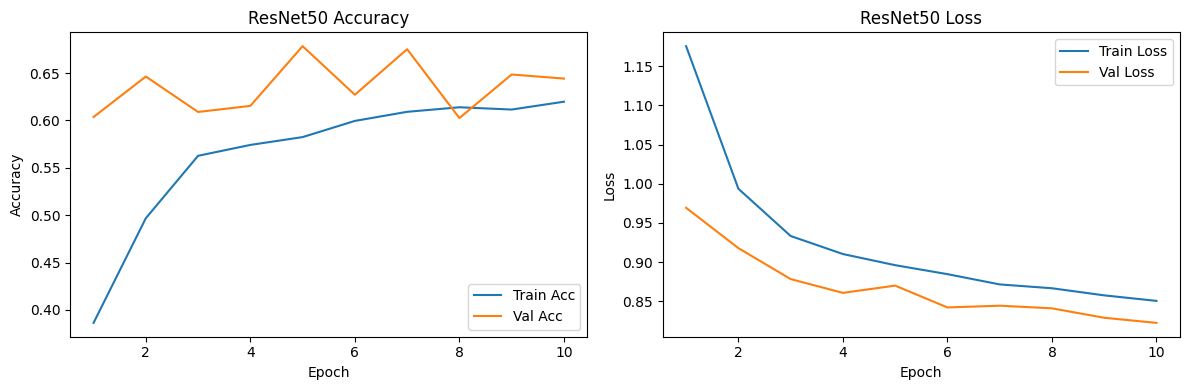

=== Classification Report: ResNet50 ===
                 precision    recall  f1-score   support

Bacterialblight     0.7119    0.6796    0.6954       309
      Brownspot     0.6322    0.8793    0.7356       348
       Leafsmut     0.5541    0.3118    0.3991       279

       accuracy                         0.6442       936
      macro avg     0.6327    0.6236    0.6100       936
   weighted avg     0.6352    0.6442    0.6220       936

ResNet50 Val Accuracy: 0.6442307829856873


In [ ]:
#ResNet50
from tensorflow.keras.applications import ResNet50

def build_resnet50_model(input_shape=IMG_SIZE + (3,), num_classes=3):
    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="resnet50_transfer")
    return model

resnet_model = build_resnet50_model(num_classes=num_classes)
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()

EPOCHS_RESNET = 10  # adjust

history_resnet = resnet_model.fit(
    train_ds,
    epochs=EPOCHS_RESNET,
    validation_data=val_ds
)

plot_history(history_resnet, model_name="ResNet50")
evaluate_and_report(resnet_model, model_name="ResNet50")

val_acc_resnet = history_resnet.history["val_accuracy"][-1]
model_accuracies["ResNet50"] = val_acc_resnet
print("ResNet50 Val Accuracy:", val_acc_resnet)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "inceptionv3_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,328,099 (85.17 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 27s 140ms/step - accuracy: 0.5944 - loss: 0.9224 - val_accuracy: 0.8397 - val_loss: 0.4390
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.8269 - loss: 0.4485 - val_accuracy: 0.8707 - val_loss: 0.3392
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.8706 - loss: 0.3657 - val_accuracy: 0.8942 - val_loss: 0.2786
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.8977 - loss: 0.2842 - val_accuracy: 0.9049 - val_loss: 0.2428
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.9091 - loss: 0.2518 - val_accuracy: 0.9220 - val_loss: 0.2150
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.9348 - loss: 0.1995 - val_accuracy: 0.9241 - val_loss: 0.1924
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9281 - loss: 0.2084 - val_accuracy: 0.9316 - val_loss: 0.1792
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9422 - loss: 0

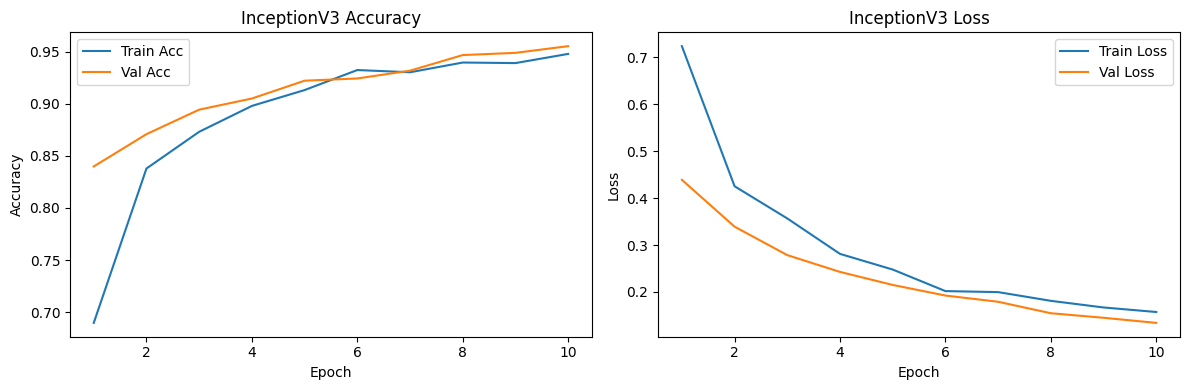

=== Classification Report: InceptionV3 ===
                 precision    recall  f1-score   support

Bacterialblight     0.9354    0.9838    0.9590       309
      Brownspot     0.9577    0.9770    0.9673       348
       Leafsmut     0.9766    0.8961    0.9346       279

       accuracy                         0.9551       936
      macro avg     0.9566    0.9523    0.9536       936
   weighted avg     0.9560    0.9551    0.9548       936

InceptionV3 Val Accuracy: 0.9551281929016113


In [ ]:
#InceptionV3
from tensorflow.keras.applications import InceptionV3

# For Inception, a larger default input size is common, but 224x224 works
def build_inceptionv3_model(input_shape=IMG_SIZE + (3,), num_classes=3):
    base_model = InceptionV3(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="inceptionv3_transfer")
    return model

inception_model = build_inceptionv3_model(num_classes=num_classes)
inception_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

inception_model.summary()

EPOCHS_INC = 10  # adjust

history_inception = inception_model.fit(
    train_ds,
    epochs=EPOCHS_INC,
    validation_data=val_ds
)

plot_history(history_inception, model_name="InceptionV3")
evaluate_and_report(inception_model, model_name="InceptionV3")

val_acc_inception = history_inception.history["val_accuracy"][-1]
model_accuracies["InceptionV3"] = val_acc_inception
print("InceptionV3 Val Accuracy:", val_acc_inception)


Model: "tiny_vit"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_10[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 14, 14,    │     49,216 │ rescaling[5][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 196, 64)   │          0 │ conv2d_100[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 196, 64)   │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 64)   │        128 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 196, 128)  │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 196, 64)   │      8,256 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 196, 64)   │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 196, 64)   │          0 │ dropout_7[0][0],  │
│                     │                   │            │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_11[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_12[0][0]    

 Total params: 390,851 (1.49 MB)

 Trainable params: 390,851 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.4160 - loss: 1.1111 - val_accuracy: 0.5235 - val_loss: 0.9289
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.6328 - loss: 0.8286 - val_accuracy: 0.6923 - val_loss: 0.7306
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.6929 - loss: 0.7314 - val_accuracy: 0.6955 - val_loss: 0.7156
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.6993 - loss: 0.6736 - val_accuracy: 0.7671 - val_loss: 0.4951
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.7259 - loss: 0.6337 - val_accuracy: 0.8237 - val_loss: 0.4159
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.7866 - loss: 0.4827 - val_accuracy: 0.7607 - val_loss: 0.5181
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.8162 - loss: 0.4285 - val_accuracy: 0.8846 - val_loss: 0.2848
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.8449 - loss: 0.3986 - val_acc

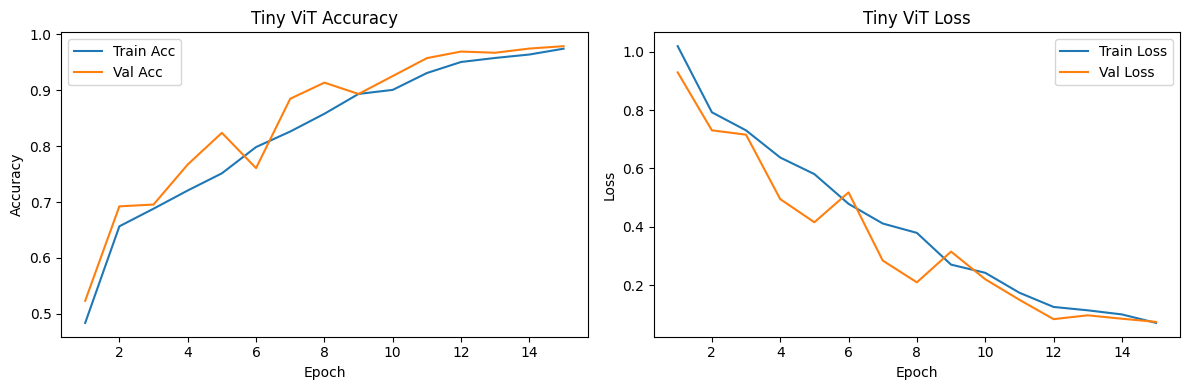

=== Classification Report: Tiny ViT ===
                 precision    recall  f1-score   support

Bacterialblight     0.9563    0.9903    0.9730       309
      Brownspot     1.0000    0.9914    0.9957       348
       Leafsmut     0.9779    0.9498    0.9636       279

       accuracy                         0.9786       936
      macro avg     0.9780    0.9772    0.9774       936
   weighted avg     0.9790    0.9786    0.9786       936

Tiny ViT Val Accuracy: 0.9786324501037598


In [ ]:
# Vision Transformer

# Encoder+decoder blocks
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation="gelu")(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def build_tiny_vit(
    input_shape=IMG_SIZE + (3,),
    num_classes=3,
    patch_size=16,
    projection_dim=64,
    transformer_layers=4,
    num_heads=4,
    mlp_head_units=[128]
):
    inputs = layers.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = preprocess_input(x)

    # Create patches
    patch_layer = layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid"
    )
    x = patch_layer(x)  # [B, H/patch, W/patch, projection_dim]

    # Flatten patches
    x = layers.Reshape((-1, projection_dim))(x)  # [B, num_patches, projection_dim]

    # Positional embedding
    num_patches = x.shape[1]
    pos_embedding = layers.Embedding(
        input_dim=num_patches,
        output_dim=projection_dim
    )
    positions = tf.range(start=0, limit=num_patches, delta=1)
    x = x + pos_embedding(positions)

    # Transformer blocks
    for _ in range(transformer_layers):
        # Layer norm + MHA
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim,
            dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, x])

        # Feed-forward
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=[projection_dim * 2, projection_dim], dropout_rate=0.1)
        x = layers.Add()([x3, x2])

    # Classification head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = mlp(x, hidden_units=mlp_head_units, dropout_rate=0.5)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="tiny_vit")
    return model

vit_model = build_tiny_vit(num_classes=num_classes)
vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

vit_model.summary()

EPOCHS_VIT = 15  # might need a bit more since it's from scratch

history_vit = vit_model.fit(
    train_ds,
    epochs=EPOCHS_VIT,
    validation_data=val_ds
)

plot_history(history_vit, model_name="Tiny ViT")
evaluate_and_report(vit_model, model_name="Tiny ViT")

val_acc_vit = history_vit.history["val_accuracy"][-1]
model_accuracies["Tiny_ViT"] = val_acc_vit
print("Tiny ViT Val Accuracy:", val_acc_vit)


Final Validation Accuracies:
Custom_CNN: 0.9669
VGG19: 0.8066
MobileNetV3_Small: 0.9765
ResNet50: 0.6442
InceptionV3: 0.9551
Tiny_ViT: 0.9786


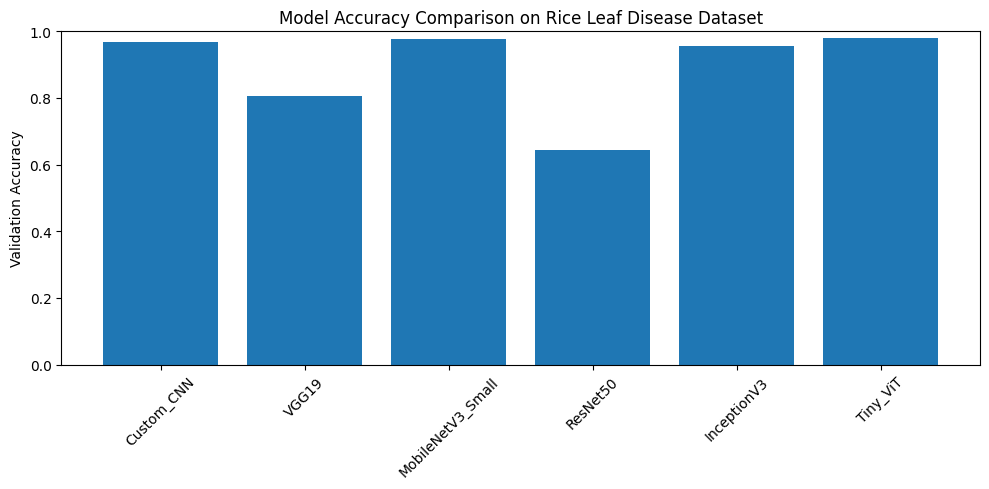

In [ ]:
# Comparision of accuracies

print("Final Validation Accuracies:")
for name, acc in model_accuracies.items():
    print(f"{name}: {acc:.4f}")

plt.figure(figsize=(10, 5))
names = list(model_accuracies.keys())
accs = [model_accuracies[n] for n in names]

plt.bar(names, accs)
plt.ylabel("Validation Accuracy")
plt.title("Model Accuracy Comparison on Rice Leaf Disease Dataset")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()
